# Modelling

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import pickle
import json

In [24]:
# load cleaned train and validation dataset
df = pd.read_csv('TrainAndValidCleaned.csv', parse_dates=["saledate"], low_memory=False)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   SalesID                              412698 non-null  int64         
 1   SalePrice                            412698 non-null  float64       
 2   MachineID                            412698 non-null  int64         
 3   ModelID                              412698 non-null  int64         
 4   datasource                           412698 non-null  int64         
 5   auctioneerID                         412698 non-null  float64       
 6   YearMade                             412698 non-null  float64       
 7   MachineHoursCurrentMeter             412698 non-null  float64       
 8   saledate                             412698 non-null  datetime64[ns]
 9   fiModelDesc                          412698 non-null  int64         
 

## Cleaning data: dropping unnecessary features

In [26]:
# First let's drop some columns that will not bring us any value to the model.
df = df.drop(['auctioneerID_is_missing', 'YearMade_is_missing', 'MachineHoursCurrentMeter_is_missing'], axis=1)
# In addition we drop saleedata that is in datetime format. This causes trouble during model fitting. We have this information in SaleX columns 
df = df.drop(['saledate'], axis=1)

Let's check if some features are correlated with each other. These which are correlated should be dropped because they dont breing any value to the model

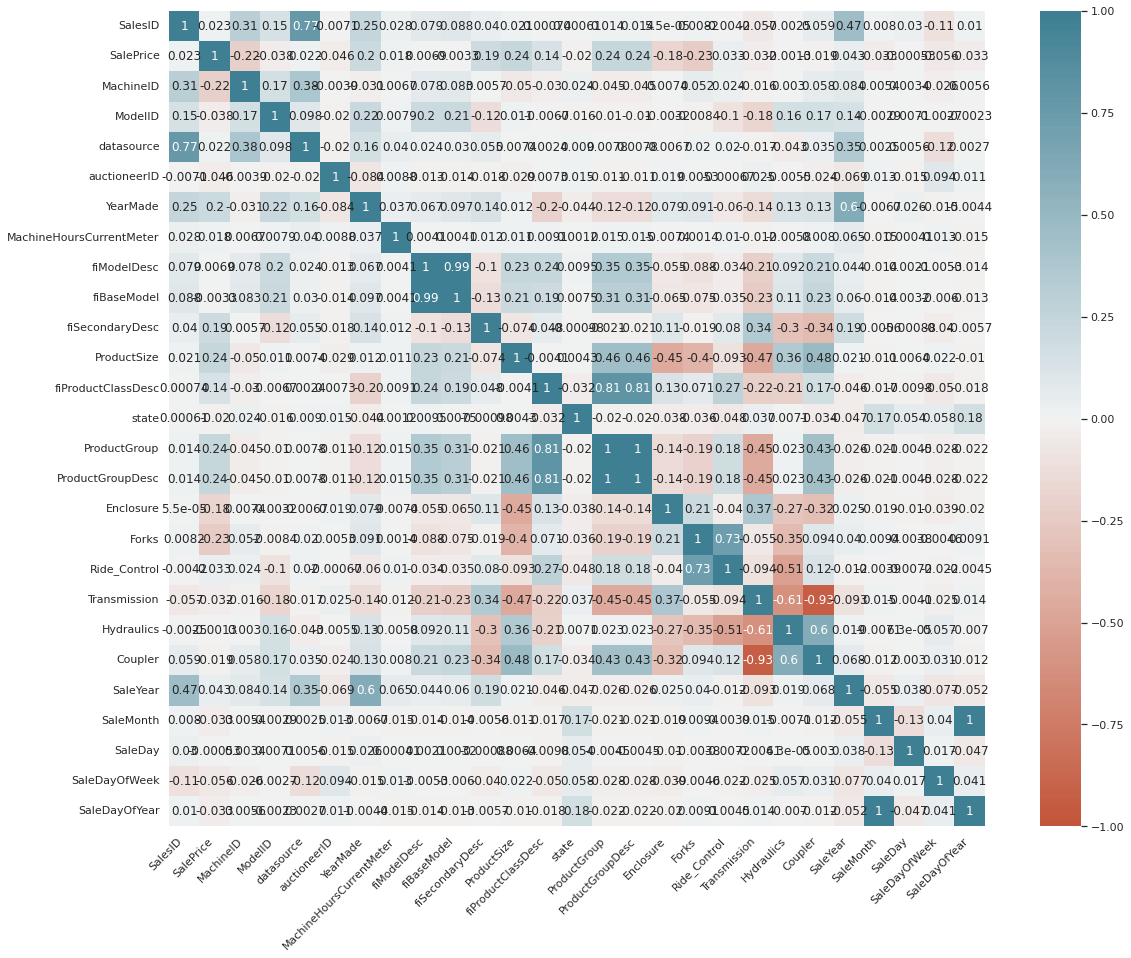

In [27]:
corr = df.corr()
sns.set(rc={'figure.figsize':(20,15)})
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [28]:
# We can easily drop: 'ProductGroupDesc', 'fiModelDesc' because they are correlated with other features
df = df.drop(['ProductGroupDesc', 'fiModelDesc'], axis=1)

### Split data into training and valid sets

In [29]:
train, valid = train_test_split(df, test_size=0.2)
X_train, y_train = train.drop(["SalePrice"], axis=1), train['SalePrice']
X_valid, y_valid = valid.drop(["SalePrice"], axis=1), valid['SalePrice']

## Base-case model training
They are many possible models and algorithms that could solve the task of predicting prices based on multiple features. In this notebook the application of the Random Forest Regressor (which is one of the most common approaches for this type of problem) is shown.

In [30]:
# n_estimators, default=100. The number of trees in the forest.
# Popular integer random seeds are 0 and 42
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### Measuring base-case model performance

Unlike classification, one cannot use classification accuracy to evaluate the predictions made by a regression model. Here the model performance will be measured by: 
- Mean Squared Error (MSE). 
- The Root Mean Squared Log Error (RMSLE) 
- R2

In [31]:
# Now let's measure model performance on the validation set
y_true = y_valid
y_pred = model.predict(X_valid)

print('MSE:', sklearn.metrics.mean_squared_error(y_true, y_pred, squared=True))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_true,y_pred)))
print('R2 score:', r2_score(y_true,y_pred))

MSE: 50954737.95840906
RMSLE: 0.21829644301413642
R2 score: 0.9034221024555115


In [32]:
# We can also check what is the performance on the training set
y_true = y_train
y_pred = model.predict(X_train)

print('MSE:', sklearn.metrics.mean_squared_error(y_true, y_pred, squared=True))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_true,y_pred)))
print('R2 score:', r2_score(y_true,y_pred))

MSE: 7195061.497024299
RMSLE: 0.08804758993923588
R2 score: 0.986614294257501


## Model tuning
The base-case model performs well on default configuration. Let's check if the model can be optimized

In [33]:
# Make a function that trains the model (with use of different params) and returns r2 scores
def train_and_measure_perf(X_train, y_train, X_valid, y_valid, n_estimators=100):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    
    y_true = y_valid
    y_pred = model.predict(X_valid)
    r2_valid = r2_score(y_true,y_pred)
    
    y_true = y_train
    y_pred = model.predict(X_train)
    r2_train = r2_score(y_true,y_pred)
    
    return r2_train, r2_valid

### Importance of features

Let's check importance of features first. Which of the parameters should be taken into consideration for the final model?

In [34]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=30):
    df = (pd.DataFrame({"features":columns,
                        "features_importances": importances})
          .sort_values("features_importances",ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe we created
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["features_importances"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Features Importance")
    ax.invert_yaxis()

# Function that returns top feature names. Number: number of top features 
def get_most_important_cats(features, importances, number):
    ind = np.argpartition(importances, -number)[-number:]
    return features[ind]

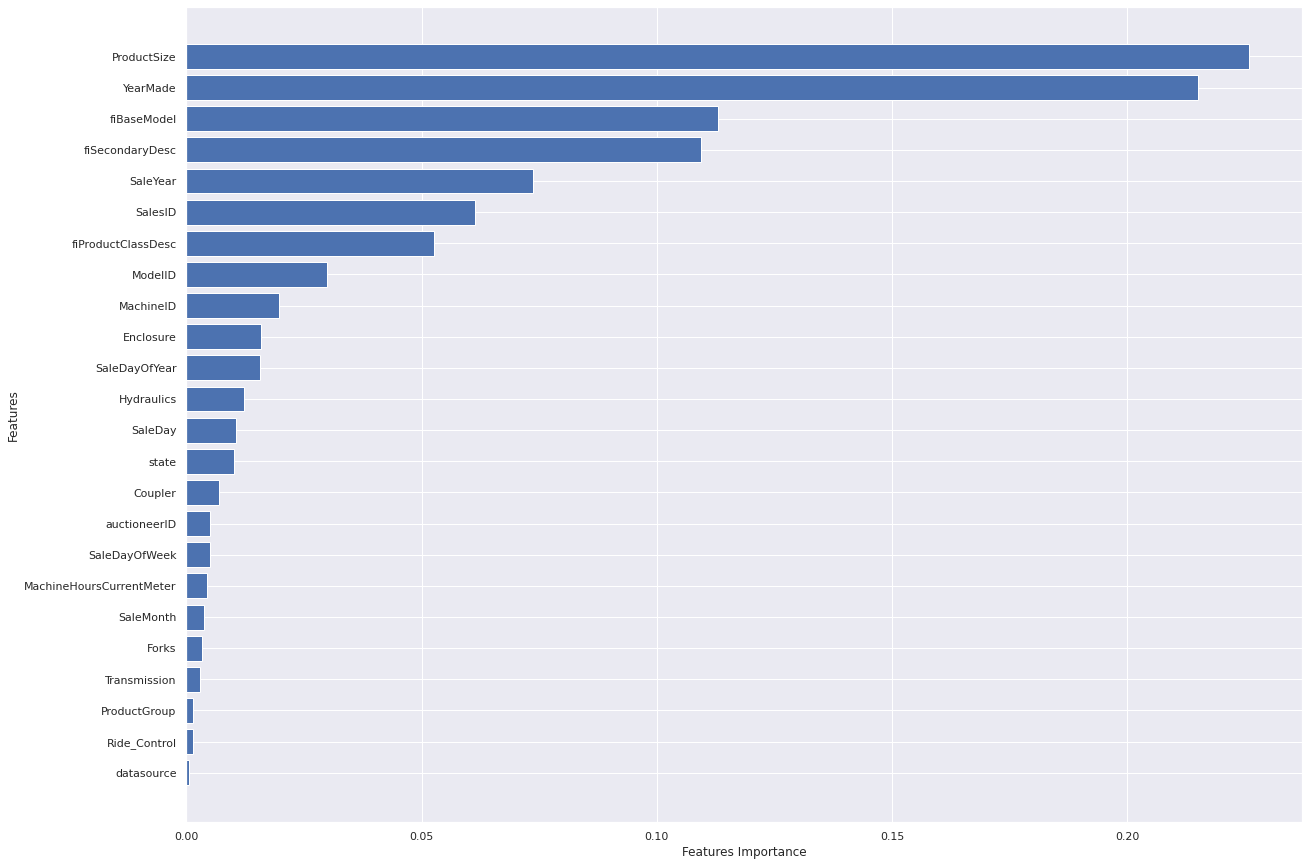

In [35]:
plot_features(X_train.columns, model.feature_importances_,len(X_train.columns))

Let's test model performance on different number of top features

In [37]:
r2_scores = []
print('number of model features,', '[r2_train,', 'r2_valid]')
for n in range(1,len(X_train.columns)):
    cats = get_most_important_cats(X_train.columns, model.feature_importances_, n)
    X_t = X_train[cats]
    X_v = X_valid[cats]
    r2_train, r2_valid = train_and_measure_perf(X_t, y_train, X_v, y_valid)
    r2_scores.append([r2_train, r2_valid])
    print(n, [r2_train, r2_valid])

number of model features, r2_train, r2_valid
1 [0.2230554610123302, 0.21892304949647445]
2 [0.39921544349159, 0.39456458176780396]
3 [0.7614087582938782, 0.74177844223915]
4 [0.7837515855572301, 0.7602988373973966]
5 [0.925385248625521, 0.8798379604476276]
6 [0.9829583311150506, 0.8776980183194196]
7 [0.9832698981109199, 0.8797554100686786]
8 [0.98342834593814, 0.8811386539212576]
9 [0.9843385142785424, 0.8872551703984758]
10 [0.9847600367051174, 0.8905801319429582]
11 [0.9862038508121667, 0.9005245676094529]
12 [0.9861711239661697, 0.9002516800896716]
13 [0.9862542977152291, 0.9005007030977253]
14 [0.9864417933547488, 0.9021367478617229]
15 [0.9864498902353561, 0.9023272411376823]
16 [0.9865200650533792, 0.9027765635761351]
17 [0.9865007250094303, 0.9027380404831806]
18 [0.9865877269322649, 0.9032170359679917]
19 [0.9865939303825132, 0.9031715283561434]
20 [0.9866028511615963, 0.9033020953350499]
21 [0.9866020631720991, 0.9033550241026853]
22 [0.9866149690674438, 0.9033290159654149]
2

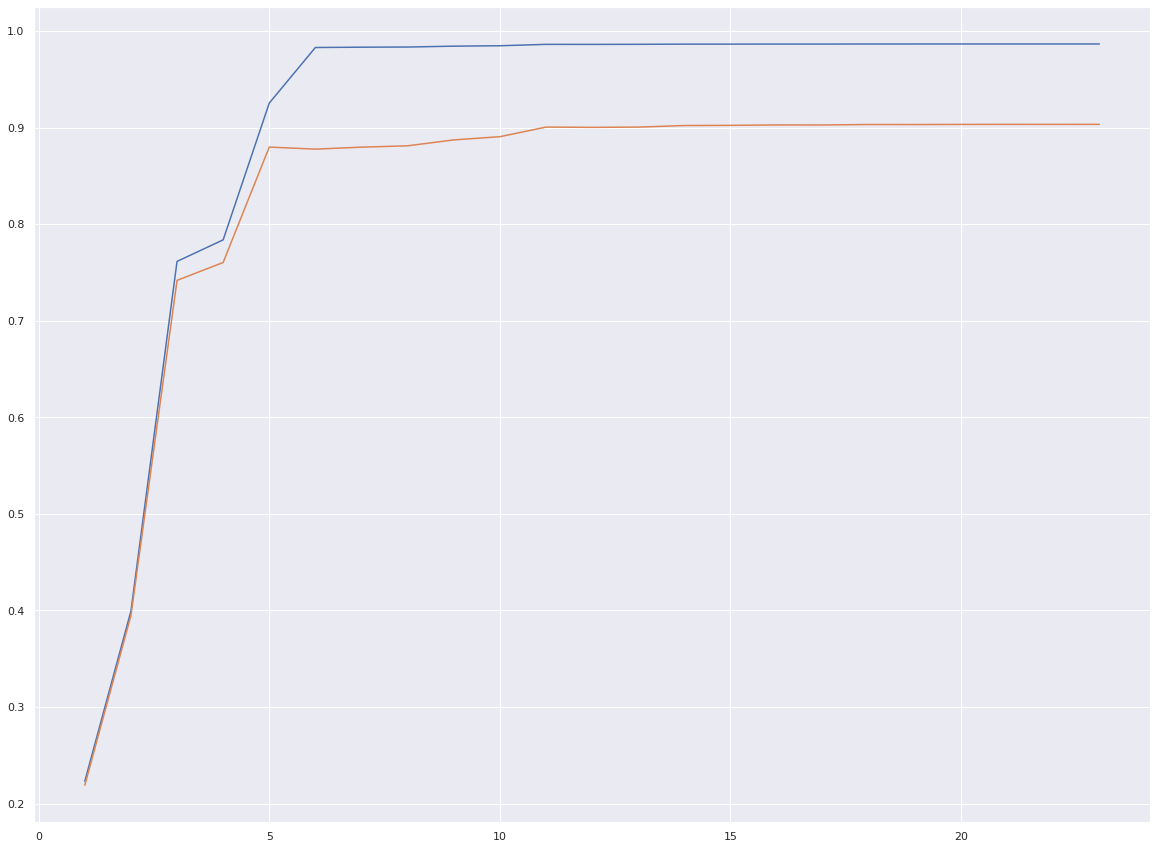

In [38]:
# Plot performance depending on number of features (orange: valid, blue: training set performance)
plt.plot([*range(1,len(X_train.columns))], r2_scores)
plt.show()

The test shows the highest prcision score (on valid data) is obtained if number of features is approximately as large as possible. The question is if we want to keep all possible features in the model. The higher number of parameters result in slower and bigger model and more complicated interaction. 

One can observe the R2 values (validation set) reach platou after 5'th top feature. It is therefore suggested that the final model should take only the top 5 features as input and do not consider the remaining features.

In [39]:
# The top 5 important features are:
top5_cats = get_most_important_cats(X_train.columns, model.feature_importances_, 5)
top5_cats

Index(['SaleYear', 'fiSecondaryDesc', 'fiBaseModel', 'ProductSize',
       'YearMade'],
      dtype='object')

### Model tree depth
Now the model tree depth (number of estimatiors) is checked for the optimal value. NB! top5 features are used for this experiment

In [46]:
# Let's test performance of the model using different tree depths (n_estimator_list)
n_estimator_list = [1,3,5,10,20,30,50,100]
r2_scores_t = []
print('tree depth,', '[r2_train,', 'r2_valid]')
for n in n_estimator_list:
    X_t = X_train[top5_cats]
    X_v = X_valid[top5_cats]
    [r2_train, r2_valid] = train_and_measure_perf(X_t, y_train, X_v, y_valid, n)
    r2_scores_t.append([r2_train, r2_valid])
    print(n, [r2_train, r2_valid])

tree depth, [r2_train, r2_valid]
1 [0.9030291642839152, 0.848470914463543]
3 [0.9180237423209523, 0.8696479895092142]
5 [0.9210348652117984, 0.8738472856751085]
10 [0.9233334181225339, 0.8768761465565581]
20 [0.9244628212663362, 0.8784134070094187]
30 [0.9248716688059778, 0.8789672009880054]
50 [0.925167330588487, 0.8793662091372537]
100 [0.925385248625521, 0.8798379604476276]


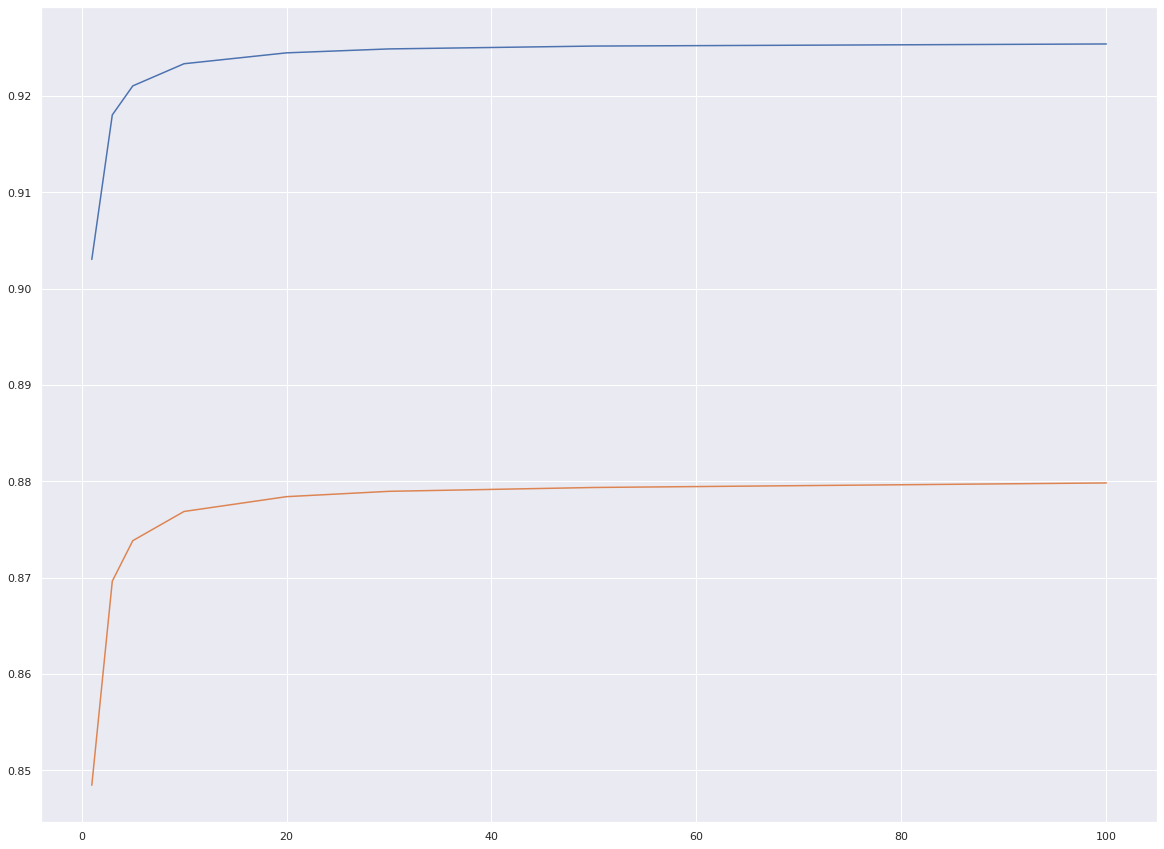

In [47]:
plt.plot([*n_estimator_list], r2_scores_t) # orange: valid, blue: training set performance
plt.show()

The best results are obtained if number of estimators is as high as possible. The downside of high estimator number is that it increases the model complexity. The performance reaches plateou at about 30, so it is suggested to use number of estimators = 30 in the final model. Let's train once again with desired combination of feature number and tree depth.

In [48]:
model = RandomForestRegressor(n_estimators=30, random_state=42)
model.fit(X_train[top5_cats], y_train)
# Let's check the final model performance. 
y_true = y_valid
y_pred = model.predict(X_valid[top5_cats])

print('MSE:', sklearn.metrics.mean_squared_error(y_true, y_pred, squared=True))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_true,y_pred)))
print('R2 score:', r2_score(y_true,y_pred))

MSE: 63857204.54504677
RMSLE: 0.23955633350226943
R2 score: 0.8789672009880054


The model R2 score is about 0.88

In [49]:
# Let's dump the model as a pickle pile
a_file = open("model.pkl", "wb")
pickle.dump(model, a_file)
a_file.close()

### Make predictions on dummy user data

In [52]:
# Let's define some dummy data that a user can type

ProductSize = 0
YearMade = 1990
fiBaseModel = 100
fiSecondaryDesc = 0
SaleYear = 2022

d = {
    'SaleYear':SaleYear,
    'fiSecondaryDesc':fiSecondaryDesc,
    'fiBaseModel':fiBaseModel, 
    'ProductSize':ProductSize, 
    'YearMade':YearMade, 
    }

df_test = pd.DataFrame(d, index=[0])
df_test

,SaleYear,fiSecondaryDesc,fiBaseModel,ProductSize,YearMade
0,2022,0,100,0,1990


In [53]:
# The following is the price for given parameters
y_test = model.predict(df_test)
print("${:.0f}". format(y_test[0]))

$14031


In [54]:
# Export category-code dictionary for relevant categories so a user knows codes. 
# The codes are obtained from a dictionary that was exported in 'Data_cleaning_exploration.ipynb'
cats_codes = pickle.load(open('cats_codes.pkl', 'rb'))
keys = ('fiBaseModel','fiSecondaryDesc', 'ProductSize')
d1 = {k: cats_codes[k] for k in keys}
a_file = open("category_description.json", "w")
json.dump(d1, a_file, indent=2)
a_file.close()